<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/Mobilenet_garbage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Directly using mobilenetv2 to train a neural network, it can give a very good accuracy (about 99%). On the other hand, using tranfer learning, a pre-trained mobilenetv2 model (imagenet) only provides about 86$. 

# 2. Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mounted at /content/drive

In [2]:
!ls "/content/drive/My Drive/Garbage classification/"


cardboard  glass  metal  paper	plastic  trash


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob, os, random
import numpy as np
import matplotlib.pyplot as plt

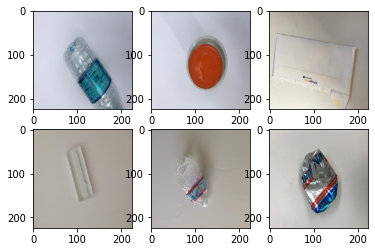

In [4]:
from keras.preprocessing import image
base_path = '/content/drive/My Drive/Garbage classification'
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)


Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [6]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((16, 224, 224, 3), (16, 6))

In [7]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)



{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [8]:
!ls

drive  labels.txt  sample_data


In [28]:
path = 'labels.txt'
label = np.array(open(path).read().splitlines())

# 3. Import MobileNetv2

In [12]:
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

If want to use transfer learning, run the following code. Otherwise, skip it.

In [13]:
for layer in base_model.layers[:-1]:
    layer.trainable=False

for i, layer in enumerate(base_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 Conv1_pad - False
2 Conv1 - False
3 bn_Conv1 - False
4 Conv1_relu - False
5 expanded_conv_depthwise - False
6 expanded_conv_depthwise_BN - False
7 expanded_conv_depthwise_relu - False
8 expanded_conv_project - False
9 expanded_conv_project_BN - False
10 block_1_expand - False
11 block_1_expand_BN - False
12 block_1_expand_relu - False
13 block_1_pad - False
14 block_1_depthwise - False
15 block_1_depthwise_BN - False
16 block_1_depthwise_relu - False
17 block_1_project - False
18 block_1_project_BN - False
19 block_2_expand - False
20 block_2_expand_BN - False
21 block_2_expand_relu - False
22 block_2_depthwise - False
23 block_2_depthwise_BN - False
24 block_2_depthwise_relu - False
25 block_2_project - False
26 block_2_project_BN - False
27 block_2_add - False
28 block_3_expand - False
29 block_3_expand_BN - False
30 block_3_expand_relu - False
31 block_3_pad - False
32 block_3_depthwise - False
33 block_3_depthwise_BN - False
34 block_3_depthwise_relu - False
35 

In [17]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.9),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         1474688   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 3,733,446
Trainable params: 3,699,334
Non-trainable params: 34,112
_________________________________________________________________


In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),   
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [19]:
batch_size = 32
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Epoch 1/50
71/71 [==============================] - 17s 236ms/step - loss: 0.3821 - acc: 0.8856 - val_loss: 1.1253 - val_acc: 0.7857
Epoch 2/50
71/71 [==============================] - 15s 213ms/step - loss: 0.1517 - acc: 0.9448 - val_loss: 1.3706 - val_acc: 0.7054
Epoch 3/50
71/71 [==============================] - 15s 215ms/step - loss: 0.1114 - acc: 0.9630 - val_loss: 0.6262 - val_acc: 0.8571
Epoch 4/50
71/71 [==============================] - 15s 214ms/step - loss: 0.1008 - acc: 0.9662 - val_loss: 0.9430 - val_acc: 0.8125
Epoch 5/50
71/71 [==============================] - 15s 213ms/step - loss: 0.0980 - acc: 0.9639 - val_loss: 0.3493 - val_acc: 0.8839
Epoch 6/50
71/71 [==============================] - 15s 213ms/step - loss: 0.1112 - acc: 0.9595 - val_loss: 0.9264 - val_acc: 0.8482
Epoch 7/50
71/71 [==============================] - 15s 214ms/step - loss: 0.1101 - acc: 0.9648 - val_loss: 0.7224 - val_acc: 0.8393
Epoch 8/50
71/71 [==============================] - 15s 214ms/step - 

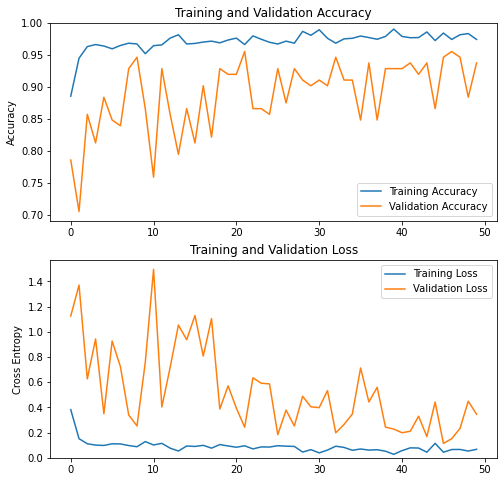

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

(1, 6)
cardboard


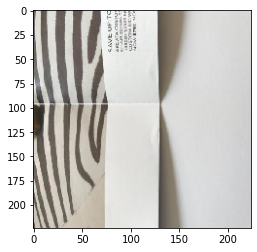

In [21]:
img_path = '/content/drive/My Drive/Garbage classification/paper/paper8.jpg'

img=np.array(img)/255.0
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
plt.imshow(img.squeeze())
p=model.predict(img[np.newaxis, ...])
print(p.shape)
predicted_class = label[np.argmax(p[0][0], axis=-1)]
print(predicted_class)

## Fine Tuning
If the base model is learnt by transfer learning, the following code is running. Otherwise, skip it.

In [21]:
# if using transfer learning
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 91

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5), 
              metrics=['acc'])

In [25]:
history_fine = model.fit(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps) 

Epoch 1/50
71/71 [==============================] - 17s 240ms/step - loss: 0.0361 - acc: 0.9929 - val_loss: 0.6232 - val_acc: 0.9286
Epoch 2/50
71/71 [==============================] - 15s 215ms/step - loss: 0.0172 - acc: 0.9964 - val_loss: 0.6172 - val_acc: 0.9464
Epoch 3/50
71/71 [==============================] - 15s 215ms/step - loss: 0.0405 - acc: 0.9902 - val_loss: 0.5349 - val_acc: 0.9107
Epoch 4/50
71/71 [==============================] - 15s 216ms/step - loss: 0.0220 - acc: 0.9920 - val_loss: 0.2973 - val_acc: 0.9375
Epoch 5/50
71/71 [==============================] - 15s 216ms/step - loss: 0.0340 - acc: 0.9912 - val_loss: 0.4103 - val_acc: 0.9375
Epoch 6/50
71/71 [==============================] - 15s 215ms/step - loss: 0.0277 - acc: 0.9893 - val_loss: 0.2300 - val_acc: 0.9732
Epoch 7/50
71/71 [==============================] - 15s 214ms/step - loss: 0.0207 - acc: 0.9938 - val_loss: 0.3594 - val_acc: 0.9643
Epoch 8/50
71/71 [==============================] - 15s 215ms/step - 

In [26]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Save the mobilenetv2 model (no tranfer learning)

In [ ]:
model.save("mobilenetv2_garbage.h5")

Otherwise, save the transfer learning mobilenetv2 model

In [ ]:
#model.save("transfer_mobilenetv2_garbge.h5")

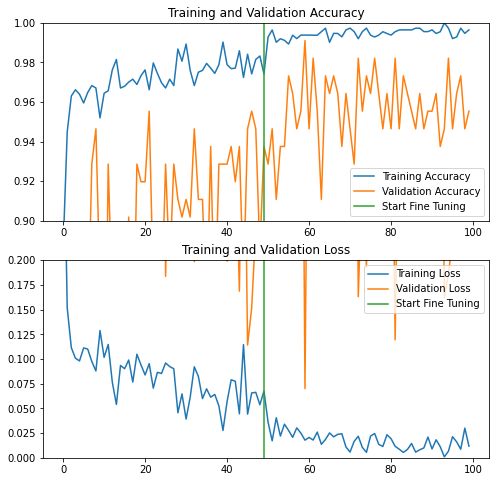

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 4. Reduced MobileNetV2

In [ ]:
#from tensorflow.contrib import lite
#file = "Garbage.h5"
#keras.models.save_model(model,file)
#converter = lite.TocoConverter.from_keras_model_file(file)
#tflite_model=conerter.convert()
#open("garbage.tflite",'wb').write(tflite_model)

In [ ]:
#import tensorflow as tf
#file = "Garbage.h5"
#keras.models.save_model(model,file)
#converter = tf.lite.TFLiteConverter.from_keras_model_file(file)
#tflite_model=converter.convert()
#open("garbage.tflite",'wb').write(tflite_model)

In [ ]:
#tf.lite.TFLiteConverter.from_saved_model("saved_model", input_shapes={("image_tensor" : [1,300,300,3])})


In [ ]:
saved_model_dir = '../'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
from IPython.display import FileLinks
FileLinks('.')

In [ ]:
import PIL.Image as Image



In [ ]:
#img=Image.open(img_path).resize((224, 224))


In [ ]:
img_path = '../input/garbage classification/Garbage classification/cardboard/cardboard5.jpg'

img=np.array(img)/255.0
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
plt.imshow(img.squeeze())
p=model.predict(img[np.newaxis, ...])
print(p.shape)
predicted_class = np.argmax(p[0], axis=-1)
print(predicted_class)

import keras
import tensorflow as tf
model = keras.models.load_model(file)
model._make_predict_function()
graph = tf.get_default_graph()

def some_route():
	...
	global graph
	with graph.as_default():
		outputs = model.predict(img)
	...

In [ ]:
#Model = tf.keras.models.load_model(file)

global graph,model
graph = tf.get_default_graph()

with graph.as_default():
     y = model.predict(img[np.newaxis, ...])

In [ ]:
#from keras import backend as K
#K.clear_session()

In [ ]:
#desired_batch_size=7
#nb_samples = len(validation_generator)
#p=model.predict_generator(validation_generator, np.ceil(nb_samples/desired_batch_size))
#K.clear_session()